In [ ]:
# We are reporting the Climate conditions, Soil properties of  Wine-producing areas in USA.
# Current conditions cannot be representative of the Climate of those areas. We need annual values (temperature,
# rainfall, soil properties) to characterize these areas. The historical weather and soil data even though 
#available are costly.And most of the websites do not fucntion well. USDA, Soil Grids had broken API-s.
# So we had to access public data (PNAS, Agromonitoring.com) which are relatively easier to find without any cost.
# Locations of these climate, soil data are different from the Wine-producing areas. So we had to lookout for the
# nearest station or the polygon that  represents the conditions for the Wine-producing location. Details are provided
# within the comment blocks in the notebook.

In [2]:
# Dependencies
import pandas as pd
import numpy as np
import gmaps
import requests
from config import gkey
from config import ow_key
import time
import pprint
import pyowm
from math import sin, cos, sqrt, atan2, radians
import matplotlib.pyplot as plt

In [3]:
#Getting the wrappers for Openweathermap and Google Cloud Maps API
owm = pyowm.OWM(ow_key)
mgr = owm.agro_manager()
from pyowm.utils.geo import Polygon as GeoPolygon
mgr = owm.agro_manager()
# Configure gmaps
gmaps.configure(api_key=gkey)

In [4]:
wine_data = "winemag-data_first150k.csv"
wine_df = pd.read_csv(wine_data)
wine_df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [5]:
wine_df2=wine_df.drop(columns= ["Unnamed: 0","region_2"], axis=1)
wine_df2.head()

,country,description,designation,points,price,province,region_1,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,Provence red blend,Domaine de la Bégude


In [6]:
dropped_wine= wine_df2.dropna()
dropped_wine.count()

country        77284
description    77284
designation    77284
points         77284
price          77284
province       77284
region_1       77284
variety        77284
winery         77284
dtype: int64

In [7]:
#Focussing just in US Data, simply because historical data of climate 
#(Annual precipitation, rainfall, soil characteristics are not available for free for the rest of the world )
us_data=dropped_wine[dropped_wine["country"]=="US"]
us_data

,country,description,designation,points,price,province,region_1,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Cabernet Sauvignon,Heitz
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Pinot Noir,Ponzi
8,US,This re-named vineyard was formerly bottled as...,Silice,95,65.0,Oregon,Chehalem Mountains,Pinot Noir,Bergström
9,US,The producer sources from two blocks of the vi...,Gap's Crown Vineyard,95,60.0,California,Sonoma Coast,Pinot Noir,Blue Farm
11,US,"From 18-year-old vines, this supple well-balan...",Estate Vineyard Wadensvil Block,95,48.0,Oregon,Ribbon Ridge,Pinot Noir,Patricia Green Cellars
12,US,A standout even in this terrific lineup of 201...,Weber Vineyard,95,48.0,Oregon,Dundee Hills,Pinot Noir,Patricia Green Cellars
14,US,"With its sophisticated mix of mineral, acid an...",Grace Vineyard,95,185.0,Oregon,Dundee Hills,Pinot Noir,Domaine Serene
15,US,"First made in 2006, this succulent luscious Ch...",Sigrid,95,90.0,Oregon,Willamette Valley,Chardonnay,Bergström
16,US,"This blockbuster, powerhouse of a wine suggest...",Rainin Vineyard,95,325.0,California,Diamond Mountain District,Cabernet Sauvignon,Hall


In [11]:
# Setting target area as the combination of province and region_1 for identifying locations
target_area = (us_data["region_1"]+","+us_data["province"])

In [12]:

unique_regions =us_data["region_1"].unique()
#unique_regions

In [13]:
# Gather the Wine Ratings data for US locations
ratings = us_data["points"]

In [14]:
# Creating a data frame for location and Wine Ratings
wv = pd.DataFrame({"Location": target_area,"Wine Ratings": ratings})
wv_group = wv.groupby("Location")
#Getting the mean ratings for a particular location
num_varieties = pd.DataFrame(wv_group["Wine Ratings"].mean()).reset_index()
#just sampling for testing purposes
#sample_num_varieties = num_varieties.sample(200)
sample_num_varieties = num_varieties
sample_num_varieties

,Location,Wine Ratings
0,"Adelaida District,California",90.700000
1,"Albemarle County,Virginia",86.000000
2,"Alexander Valley,California",88.160920
3,"Alta Mesa,California",87.181818
4,"Amador County,California",86.839117
5,"Amador-Napa,California",84.000000
6,"Ancient Lakes,Washington",86.875000
7,"Anderson Valley,California",90.149701
8,"Anderson Valley-Sonoma County-Cole Ranch,Calif...",87.000000
9,"Applegate Valley,Oregon",86.870968


In [15]:
# create a params dict that will be updated with each location
params = {"key": gkey}
base_url = "https://maps.googleapis.com/maps/api/geocode/json"
# Loop through the locations and run a lat/long search for each location
for idx, row in sample_num_varieties.iterrows():
#    print(idx)
    sample_target = row["Location"]
    # update address key value
    params['address'] = f"{sample_target}"
    # make request
    location_lat_lng = requests.get(base_url, params=params)
    # convert to json
    location_lat_lng = location_lat_lng.json()
    lat_long_geo = location_lat_lng["results"][0]["geometry"]
    try:
        # Get the latitude and longitude of the place
        latitude = lat_long_geo["location"]["lat"]
        longitude = lat_long_geo["location"]["lng"]
        
        
        # ---Soil Properties (Moisture and Soil Temperature) from Agromonitoring.com (partner website of Openweathermap)----
        # Creating bounds for the location to construct a polygon needed to get access to the soil data. 
        #Could have used google geometry bounds but we have some locations as Oregon, Oregon or California, California
        # as region and province, which would have given bigger geometrical bounds than the actual winery.
        north = latitude  + 0.01
        south = latitude  - 0.01
        east =  longitude + 0.01
        west =  longitude - 0.01
        # Refer to documentation, why Agromonitoring return soil properties of a area demarcated by polygon instead 
        #of a latitude and longitude (https://agromonitoring.com/api/polygons). We have to construct a polygone given
        #by the geometrical bounds. 
        try:
            gp = GeoPolygon([[
                [east, north],
                [west, north],
                [west, south],
               [east, south],
                [east, north]]])
            # mgr is the wrapper for API call to Agromonitoring, creating a polygon
            polygon = mgr.create_polygon(gp, 'my new shiny polygon')
            try:
                # Getting soil properties via the polygon 
                soil = mgr.soil_data(polygon) 
                sample_num_varieties.loc[idx, "Lat"] = latitude
                sample_num_varieties.loc[idx, "Lng"] = longitude  
                sample_num_varieties.loc[idx, "Soil Temperature (C) at 10 cm depth"] = soil.ten_cm_temp(unit='celsius') 
                sample_num_varieties.loc[idx, "Soil Moisture"] = soil.moisture
            except(AssertionError):
                continue
        except( pyowm.exceptions.OWMError ):
            continue
    except(KeyError, IndexError):
        print("Missing field/result... skipping.")
        continue
    time.sleep(3)
# Drop the missing values
sample_num_varieties = sample_num_varieties.dropna()

In [16]:
sample_num_varieties.count()

Location                               243
Wine Ratings                           243
Lat                                    243
Lng                                    243
Soil Temperature (C) at 10 cm depth    243
Soil Moisture                          243
dtype: int64

In [17]:
#Writing the data for Wine Ratings and soil data to csv format
sample_num_varieties.to_csv("Wine_Soil.csv")

In [18]:
# Creating a dataframe from the Wine Ratings and soil data
post_process = pd.read_csv("Wine_Soil.csv")               

In [19]:
# Accessing PNAS data for Annual Precipitation, Annual Average Temperature and pH of Soil in a given latitude and longitude
#Reference to the data :- Simkin et al. 2016 PNAS data on herbaceous species richness 
#and associated plot and covariate information 
(https://catalog.data.gov/dataset/simkin-et-al-2016-pnas-data-on-herbaceous-species-richness-and-associated-plot-and-covaria)

pnas_df = pd.read_csv("PNAS_Data/PNAS.csv")
pnas_df.head(100)

,latitude,longitude,spp_richness,N_dep_kghayr,precip_mm,temp_C_ave,pH,CL_kghayr_lower,CL_kghayr_upper,CL_kghayr,EX_kghayr,two_class_veg,NVC_1_name,NVC_2_name,NVC_Alliance,proj_orig
0,46.1,-83.7,15,5.52,805.57,5.61,7.2,15.86,19.38,17.43,-11.91,closed_canopy,Forest,Deciduous forest,Acer saccharum - Betula alleghaniensis - (Fagu...,Alvar
1,46.1,-83.7,11,5.52,805.57,5.61,7.2,15.86,19.38,17.43,-11.91,closed_canopy,Forest,Deciduous forest,Acer saccharum - Betula alleghaniensis - (Fagu...,Alvar
2,46.1,-83.7,12,5.52,805.57,5.61,7.2,15.86,19.38,17.43,-11.91,closed_canopy,Forest,Deciduous forest,Acer saccharum - Betula alleghaniensis - (Fagu...,Alvar
3,46.1,-83.7,17,5.52,805.57,5.61,7.2,15.86,19.38,17.43,-11.91,closed_canopy,Forest,Deciduous forest,Acer saccharum - Betula alleghaniensis - (Fagu...,Alvar
4,46.1,-83.7,16,5.52,805.57,5.61,7.2,15.86,19.38,17.43,-11.91,closed_canopy,Forest,Deciduous forest,Acer saccharum - Betula alleghaniensis - (Fagu...,Alvar
5,46.1,-83.7,12,5.52,805.57,5.61,7.2,15.86,19.38,17.43,-11.91,closed_canopy,Forest,Deciduous forest,Acer saccharum - Betula alleghaniensis - (Fagu...,Alvar
6,45.7,-86.6,25,5.72,732.15,5.98,7.0,8.85,9.22,9.03,-3.31,open_canopy,Shrubland,Evergreen shrubland,Juniperus communis Shrubland Alliance,Alvar
7,45.3,-83.6,19,8.89,751.28,6.67,7.3,8.98,9.35,9.16,-0.27,open_canopy,Shrubland,Evergreen shrubland,Juniperus communis Shrubland Alliance,Alvar
8,46.0,-83.7,15,8.63,782.47,5.69,7.2,15.86,19.38,17.43,-8.81,closed_canopy,Forest,Deciduous forest,Acer saccharum - Betula alleghaniensis - (Fagu...,Alvar
9,46.1,-84.9,17,7.94,822.37,5.05,5.6,13.08,15.04,13.96,-6.02,closed_canopy,Forest,Evergreen forest,Pinus strobus Forest Alliance,Alvar


In [20]:
pnas_group = pnas_df.groupby(["latitude","longitude"]).mean()
pnas_group = pnas_group.reset_index()

In [30]:
pnas_reduced = pnas_group[["latitude","longitude","precip_mm","temp_C_ave","pH"]]

In [31]:
# PNAS Data for latitude, and longitude
pnas_dat_lat = pnas_reduced["latitude"]
pnas_dat_lng = pnas_reduced["longitude"]
pnas_reduced

,latitude,longitude,precip_mm,temp_C_ave,pH
0,27.3,-82.3,1470.280000,22.780000,4.600000
1,27.6,-81.3,1268.560000,22.500000,5.000000
2,27.6,-81.1,1307.155000,22.625000,4.450000
3,27.7,-81.3,1304.297500,22.392500,4.475000
4,27.7,-81.2,1324.100000,22.470000,4.300000
5,28.0,-81.1,1289.910000,22.280000,5.000000
6,28.1,-81.4,1210.510000,22.440000,4.500000
7,28.2,-82.6,1326.850000,22.050000,4.600000
8,28.3,-82.6,1328.430000,22.100000,4.700000
9,28.7,-82.4,1326.970000,21.590000,5.050000


In [23]:
#Idea is to calculate the NEAREST distance between pairs of lat, long in our Wine Data and lat,long pair mentioned
#in PNAS data, and use the PNAS Data's values for Annual Rainfall, Annual Average Temp, pH of Soil as representative
#values for the Wine-growing areas. 

# Distance between pairs of lat,long are calculated by HAVERSINE formula. 
#(http://www.movable-type.co.uk/scripts/latlong.html)
dist=[]
R =6373
# Iterating over each pair of lat,long pair in WINE data
for idx, row in post_process.iterrows():
    wine_lat = radians(row["Lat"])
    wine_lng = radians(row["Lng"])
    # Iterating over each pair of lat,long pair in PNAS data
    for i in range(len(pnas_dat_lat)):
            dlon = radians(pnas_dat_lng[i]) - wine_lng
            dlat = radians(pnas_dat_lat[i]) - wine_lat

            a = (sin(dlat/2))**2 + cos(wine_lat) * cos(radians(pnas_dat_lat[i])) * (sin(dlon/2))**2 
            c = 2 * atan2( sqrt(a), sqrt(1-a) ) 
            distance = R * c 
            dist.append(distance)
    # Returning the index in the "distance "  list, where it is minimum.   
    ind = np.argmin(dist)
    # Accessing the row data for variables of interest in PNAS data and assigning to corresponding Wine data
    post_process.loc[idx, "Precipitation(mm)"] = pnas_reduced.iloc[ind,2]
    post_process.loc[idx, "Avg. Air Temp (C)"] = pnas_reduced.iloc[ind,3]
    post_process.loc[idx, "pH(Soil)"] = pnas_reduced.iloc[ind,4]
    dist=[]
   

In [24]:
post_process.columns

Index(['Unnamed: 0', 'Location', 'Wine Ratings', 'Lat', 'Lng',
       'Soil Temperature (C) at 10 cm depth', 'Soil Moisture',
       'Precipitation(mm)', 'Avg. Air Temp (C)', 'pH(Soil)'],
      dtype='object')

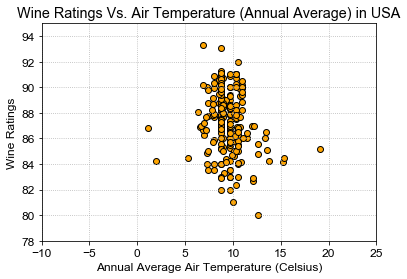

In [25]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams['font.size'] = 12
x1 = post_process["Avg. Air Temp (C)"]
y1 = post_process["Wine Ratings"]
plt.xlim(-10, 25)
plt.ylim(78, 95)
plt.scatter(x1, y1, marker="o", facecolors="orange", edgecolors="black")
plt.title("Wine Ratings Vs. Air Temperature (Annual Average) in USA")
plt.xlabel("Annual Average Air Temperature (Celsius)")
plt.ylabel("Wine Ratings", fontname="Arial", fontsize=12)
plt.grid(linestyle='dotted')
plt.savefig("Ratings_Air_Temp.png",dpi=200)

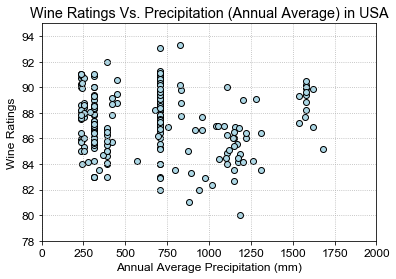

In [26]:
x1 = post_process["Precipitation(mm)"]
y1 = post_process["Wine Ratings"]
plt.xlim(0, 2000)
plt.ylim(78, 95)
plt.scatter(x1, y1, marker="o", facecolors="lightblue", edgecolors="black")
plt.title("Wine Ratings Vs. Precipitation (Annual Average) in USA")
plt.xlabel("Annual Average Precipitation (mm)")
plt.ylabel("Wine Ratings")
plt.grid(linestyle='dotted')
plt.savefig("Ratings_Precip.png",dpi=200)

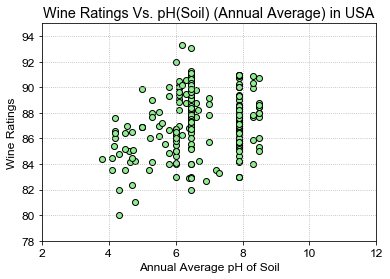

In [27]:
x1 = post_process["pH(Soil)"]
y1 = post_process["Wine Ratings"]
plt.xlim(2, 12)
plt.ylim(78, 95)
plt.scatter(x1, y1, marker="o", facecolors="lightgreen", edgecolors="black")
plt.title("Wine Ratings Vs. pH(Soil) (Annual Average) in USA")
plt.xlabel("Annual Average pH of Soil")
plt.ylabel("Wine Ratings")
plt.grid(linestyle='dotted')
plt.savefig("Ratings_Soil_pH.png",dpi=200)


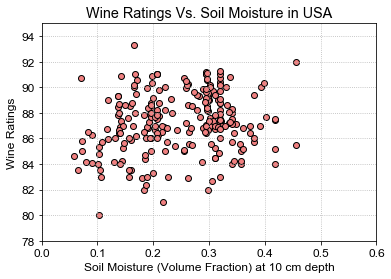

In [28]:
x1 = post_process["Soil Moisture"]
y1 = post_process["Wine Ratings"]
plt.xlim(0, 0.6)
plt.ylim(78, 95)
plt.scatter(x1, y1, marker="o", facecolors="lightcoral", edgecolors="black")
plt.title("Wine Ratings Vs. Soil Moisture in USA")
plt.xlabel("Soil Moisture (Volume Fraction) at 10 cm depth")
plt.ylabel("Wine Ratings")
plt.grid(linestyle='dotted')
plt.savefig("Ratings_Soil_Moisture.png",dpi=200)


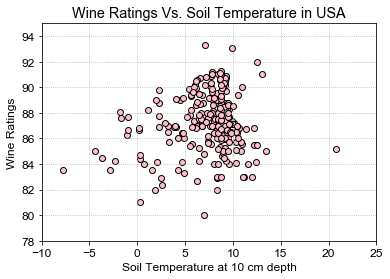

In [29]:
x1 = post_process["Soil Temperature (C) at 10 cm depth"]
y1 = post_process["Wine Ratings"]
plt.xlim(-10, 25)
plt.ylim(78, 95)
plt.scatter(x1, y1, marker="o", facecolors="pink", edgecolors="black")
plt.title("Wine Ratings Vs. Soil Temperature in USA")
plt.xlabel("Soil Temperature at 10 cm depth")
plt.ylabel("Wine Ratings")
plt.grid(linestyle='dotted')
plt.savefig("Ratings_Soil_Temp.png",dpi=200)
